In [3]:
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
            
        return x
    
    def loss(self, x, t):
        '''
        すべてのレイヤーを淳方向に通過させる
        '''
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, y ,t):
        loss_W = lambda W: self.loss(y, t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads

    def gradient(self, x, t):
        self.loss(x, t)
        dout = 1
        # 最終レイヤ（損失関数）の逆伝搬
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        # すべてのレイヤで逆伝搬処理
        # 解析的微分によって勾配を取得する
        for layer in layers:
            dout = layer.backward(dout)

        # 書くレイヤで新しい勾配を保持しているのでそれらを取得して
        # 新しい勾配とする
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads

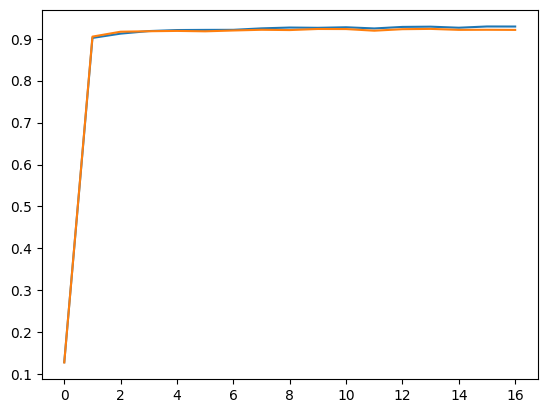

In [10]:
# メイン処理
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# ハイパーパラメータ
iter_num = 10000
train_size = x_train.shape[0] # 60000
batch_size  = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size/batch_size, 1)

for i in range(iter_num):
    batch_mask = np.random.choice(train_size, batch_size)
    # 適当にバッチデータを選ぶ
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配産出
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータ更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 検証データ表示用でメインの処理ではない
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
    
# グラフ書いちゃう
import matplotlib.pyplot as plt

plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.show()